### XGBoost Binary Classification on HTRU2 Pulsar Data

In [1]:
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')
from timeit import default_timer as timer

from sklearn import metrics, model_selection, preprocessing
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from itertools import cycle, islice
import shap as sh

import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle

In [2]:
path = "../data"

pulsar_data = pd.read_csv(path + "/input/HTRU2/HTRU_2.csv", 
                          low_memory=False, index_col=False, header=0, 
                          names=["mean_IP", "standDev_IP", "excessKurt_IP", "skewness_IP", 
                                 "mean_DMSNR", "standDev_DMSNR", "excessKurt_DMSNR", "skewness_DMSNR", "pulsar"])
print(pulsar_data.head())

      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  102.507812    58.882430       0.465318    -0.515088    1.677258   
1  103.015625    39.341649       0.323328     1.051164    3.121237   
2  136.750000    57.178449      -0.068415    -0.636238    3.642977   
3   88.726562    40.672225       0.600866     1.123492    1.178930   
4   93.570312    46.698114       0.531905     0.416721    1.636288   

   standDev_DMSNR  excessKurt_DMSNR  skewness_DMSNR  pulsar  
0       14.860146         10.576487      127.393580       0  
1       21.744669          7.735822       63.171909       0  
2       20.959280          6.896499       53.593661       0  
3       11.468720         14.269573      252.567306       0  
4       14.545074         10.621748      131.394004       0  


In [3]:
confirmed_pulsar = pulsar_data[pulsar_data['pulsar'] == 1]
confirmed_noise = pulsar_data[pulsar_data['pulsar'] == 0]

print(confirmed_pulsar.head())
print(confirmed_noise.head())

       mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
18   99.367188    41.572202       1.547197     4.154106   27.555184   
41  120.554688    45.549905       0.282924     0.419909    1.358696   
60   27.765625    28.666042       5.770087    37.419009   73.112876   
91   23.625000    29.948654       5.688038    35.987172  146.568562   
92   94.585938    35.779823       1.187309     3.687469    6.071070   

    standDev_DMSNR  excessKurt_DMSNR  skewness_DMSNR  pulsar  
18       61.719016          2.208808        3.662680       1  
41       13.079034         13.312141      212.597029       1  
60       62.070220          1.268206        1.082920       1  
91       82.394624         -0.274902       -1.121848       1  
92       29.760400          5.318767       28.698048       1  
      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  102.507812    58.882430       0.465318    -0.515088    1.677258   
1  103.015625    39.341649       0.323328     1.051164 

In [4]:
positive_train_paper_split = confirmed_pulsar.iloc[:200]
negative_train_paper_split = confirmed_noise.iloc[:200]
positive_test_paper_split = confirmed_pulsar.iloc[200:]
negative_test_paper_split = confirmed_noise.iloc[200:]

train_paper_split = pd.concat([positive_train_paper_split, negative_train_paper_split],
                               ignore_index=True, sort=False)
test_paper_split = pd.concat([positive_test_paper_split, negative_test_paper_split],
                               ignore_index=True, sort=False)

train_paper_split = train_paper_split.sample(frac=1).reset_index(drop=True)
test_paper_split = test_paper_split.sample(frac=1).reset_index(drop=True)

X_train_paper_split = train_paper_split.iloc[:, :8]
X_test_paper_split = test_paper_split.iloc[:, :8]
y_train_paper_split = train_paper_split.iloc[:, 8]
y_test_paper_split = test_paper_split.iloc[:, 8]

print(X_train_paper_split.shape)
print(X_train_paper_split.head())
print(X_test_paper_split.shape)
print(X_test_paper_split.head())
print(y_train_paper_split.shape)
print(y_train_paper_split.head())
print(y_test_paper_split.shape)
print(y_test_paper_split.head())

(400, 8)
      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0   92.468750    37.789495       0.647793     2.055608    0.864548   
1  107.875000    37.330659       0.496005     1.481816    1.173913   
2   51.015625    29.882317       4.187785    24.432051   40.172241   
3  140.976562    57.442426      -0.199055    -0.506535   13.015050   
4   87.703125    46.230631       1.302490     2.084024   20.151338   

   standDev_DMSNR  excessKurt_DMSNR  skewness_DMSNR  
0       11.983407         15.355447      256.424157  
1       12.016913         14.534290      252.694738  
2       74.420495          1.665058        1.323527  
3       42.233462          3.367501       10.692528  
4       53.706277          2.744228        6.484419  
(17497, 8)
      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  107.570312    53.204306       0.444993    -0.200185    1.887960   
1  108.906250    48.726507      -0.005444     0.279033  103.093645   
2  128.421875    50.56610

In [4]:
X, y = pulsar_data.iloc[:, :8], pulsar_data.iloc[:, 8]

X_ts = preprocessing.StandardScaler().fit_transform(X)

print(X.head())
print(y.head())

      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  102.507812    58.882430       0.465318    -0.515088    1.677258   
1  103.015625    39.341649       0.323328     1.051164    3.121237   
2  136.750000    57.178449      -0.068415    -0.636238    3.642977   
3   88.726562    40.672225       0.600866     1.123492    1.178930   
4   93.570312    46.698114       0.531905     0.416721    1.636288   

   standDev_DMSNR  excessKurt_DMSNR  skewness_DMSNR  
0       14.860146         10.576487      127.393580  
1       21.744669          7.735822       63.171909  
2       20.959280          6.896499       53.593661  
3       11.468720         14.269573      252.567306  
4       14.545074         10.621748      131.394004  
0    0
1    0
2    0
3    0
4    0
Name: pulsar, dtype: int64


In [5]:
X_train_3fold, X_test_3fold, y_train_3fold, y_test_3fold = model_selection.train_test_split(X, y, test_size=0.33, 
                                                                            random_state=42, stratify=y)

In [6]:
X_train_5fold, X_test_5fold, y_train_5fold, y_test_5fold = model_selection.train_test_split(X, y, test_size=0.2, 
                                                                            random_state=42, stratify=y)

In [7]:
X_train_10fold, X_test_10fold, y_train_10fold, y_test_10fold = model_selection.train_test_split(X, y, test_size=0.1, 
                                                                            random_state=42, stratify=y)

In [8]:
X_train_3fold_s, X_test_3fold_s, y_train_3fold_s, y_test_3fold_s = model_selection.train_test_split(X_ts, y, test_size=0.33, 
                                                                            random_state=42, stratify=y)

In [340]:
positive_weight = 16258/1639 # recommended method for findinng positve weight for imbalanced data

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5], 
        'scale_pos_weight': [1, 2, positive_weight, 25]
        }

skf =  model_selection.StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid =  model_selection.GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_3fold, y_train_3fold), verbose=3)

startTrain = timer()
model_3f = grid.fit(X_train_3fold, y_train_3fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
6031.900605294999


In [341]:
print(grid.best_params_)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 2, 'subsample': 1.0}


In [342]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=3, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [343]:
y_pred = model_3f.predict(X_test_3fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_3fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.92%


In [344]:
auc = metrics.roc_auc_score(y_test_3fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

auc: 93.45%


Confusion matrix
[[5308   58]
 [  65  476]]


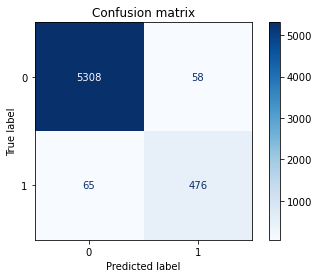

In [345]:
disp = plot_confusion_matrix(model_3f, X_test_3fold, y_test_3fold,
                                 cmap=plt.cm.Blues)
title = "Confusion matrix"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [372]:
positive_weight = 16258/1639

params = params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5], 
        'scale_pos_weight': [0.5, 1, 2, positive_weight]
        }

skf =  model_selection.StratifiedKFold(n_splits=3, shuffle = True, random_state=42)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid =  model_selection.GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, 
                                     cv=skf.split(X_train_paper_split, y_train_paper_split), 
                                     verbose=3)

startTrain = timer()
model_ps = grid.fit(X_train_paper_split, y_train_paper_split)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
2379.0667642080007


In [373]:
print(grid.best_params_)

{'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 1, 'subsample': 0.6}


In [374]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [375]:
y_pred = model_ps.predict(X_test_paper_split)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_paper_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.23%


In [552]:
auc = metrics.roc_auc_score(y_test_paper_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

auc: 94.02%


Confusion matrix
[[15299   759]
 [  104  1335]]


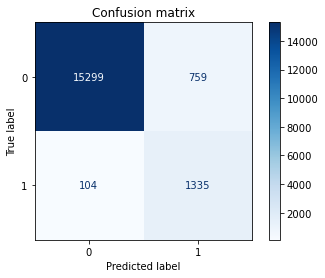

In [553]:
disp = plot_confusion_matrix(model_ps, X_test_paper_split, y_test_paper_split,
                                 cmap=plt.cm.Blues)
title = "Confusion matrix"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [9]:
xgb = XGBClassifier(colsample_bytree=0.8, gamma=0.5, max_depth=3, 
                    min_child_weight=5, subsample=1.0, scale_pos_weight=0.2, 
                    learning_rate=0.02, n_estimators=600, 
                    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

startTrain = timer()
model_ps_a = xgb.fit(X_train_paper_split, y_train_paper_split)
endTrain = timer()

print(endTrain -  startTrain)

0.2019265699999977


In [10]:
y_pred = model_ps_a.predict(X_test_paper_split)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_paper_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.75%


auc: 92.35%


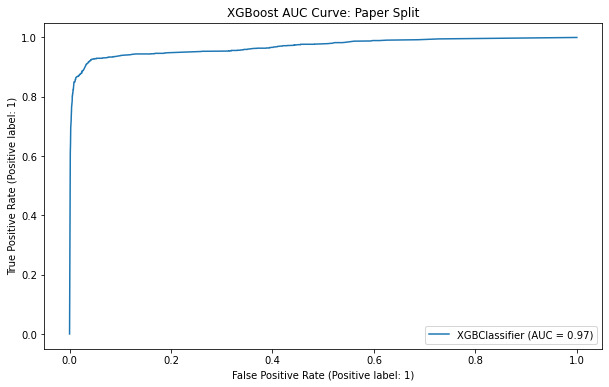

In [11]:
auc = metrics.roc_auc_score(y_test_paper_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp = plot_roc_curve(model_ps_a, X_test_paper_split, y_test_paper_split)
title = "XGBoost AUC Curve: Paper Split"
disp.ax_.set_title(title)

plt.savefig(path + "/output/XGBoost_ps_a_AUC.png", bbox_inches='tight')
plt.show()

In [12]:
fmeasure = metrics.f1_score(y_test_paper_split, predictions)
print("F-measure: %.2f%%" % (fmeasure * 100.0))

F-measure: 86.25%


In [13]:
precision = metrics.precision_score(y_test_paper_split, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

Precision: 86.62%


In [14]:
recall = metrics.recall_score(y_test_paper_split, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 85.89%


XGBoost Confusion matrix: Paper Split
[[15867   191]
 [  203  1236]]


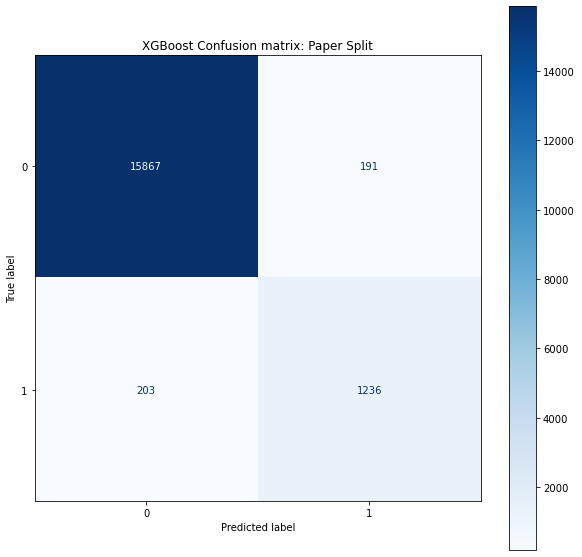

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test_paper_split, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]
disp = plot_confusion_matrix(model_ps_a, X_test_paper_split, y_test_paper_split,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: Paper Split"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/XGBoost_ps_a_Confusion.png", bbox_inches='tight')
plt.show()

In [16]:
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Specificity: 98.81%


In [17]:
fpr = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr * 100.0))

False Positive Rate: 1.19%


In [18]:
g_mean = math.sqrt(precision*recall)
print("G-mean: %.2f%%" % (g_mean * 100.0))

G-mean: 86.25%


In [277]:
metrics_df = pd.DataFrame([['Lyons', 'XGBoost', g_mean, fmeasure, recall, precision, specificity, fpr, accuracy, auc]], 
                          columns=['Split', 'Algorithm', 'G-Mean', 'F-Score', 
                                    'Recall', 'Precision', 'Specificity', 'FPR', 'Accuracy', 'AUC'])

print(metrics_df)

   Split Algorithm    G-Mean   F-Score   Recall  Precision  Specificity  \
0  Lyons   XGBoost  0.862534  0.862526  0.85893   0.866153     0.988106   

        FPR  Accuracy       AUC  
0  0.011894  0.977482  0.923518  


In [562]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5], 
        'scale_pos_weight': [1, 2, positive_weight, 25]
        }

skf =  model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid =  model_selection.GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_5fold, y_train_5fold), verbose=3)

startTrain = timer()
model_5f = grid.fit(X_train_5fold, y_train_5fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
12260.174202032009


In [563]:
print(grid.best_params_)

{'colsample_bytree': 0.8, 'gamma': 5, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 2, 'subsample': 1.0}


In [564]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=5, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [565]:
y_pred = model_5f.predict(X_test_5fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_5fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.74%


In [566]:
auc = metrics.roc_auc_score(y_test_5fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

auc: 93.13%


Confusion matrix
[[3212   40]
 [  41  287]]


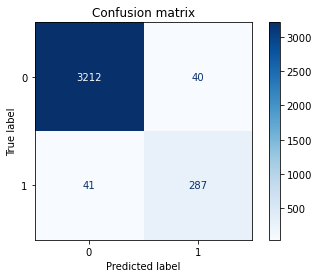

In [567]:
disp = plot_confusion_matrix(model_5f, X_test_5fold, y_test_5fold,
                                 cmap=plt.cm.Blues)
title = "Confusion matrix"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [568]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [3, 4, 5], 
        'scale_pos_weight': [1, 2, positive_weight]
        }

skf =  model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid =  model_selection.GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_10fold, y_train_10fold), verbose=3)

startTrain = timer()
model_10f = grid.fit(X_train_10fold, y_train_10fold)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 10 folds for each of 810 candidates, totalling 8100 fits
14518.773802662006


In [569]:
print(grid.best_params_)

{'colsample_bytree': 0.8, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 2, 'subsample': 1.0}


In [570]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [571]:
y_pred = model_10f.predict(X_test_10fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_10fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.32%


In [572]:
auc = metrics.roc_auc_score(y_test_10fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

auc: 91.94%


Confusion matrix
[[1602   24]
 [  24  140]]


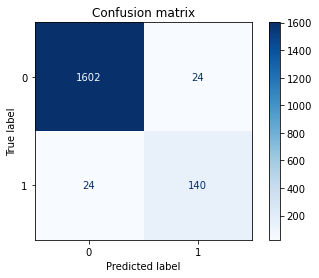

In [573]:
disp = plot_confusion_matrix(model_10f, X_test_10fold, y_test_10fold,
                                 cmap=plt.cm.Blues)
title = "Confusion matrix"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [19]:
xgb = XGBClassifier(colsample_bytree=1.0, gamma=1.5, max_depth=3, 
                    min_child_weight=1, scale_pos_weight=1, 
                    learning_rate=0.02, n_estimators=600, 
                    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

startTrain = timer()
model_10f_a = xgb.fit(X_train_10fold, y_train_10fold)
endTrain = timer()

print(endTrain -  startTrain)

1.9369090710000023


In [20]:
y_pred = model_10f_a.predict(X_test_10fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_10fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.65%


auc: 92.13%


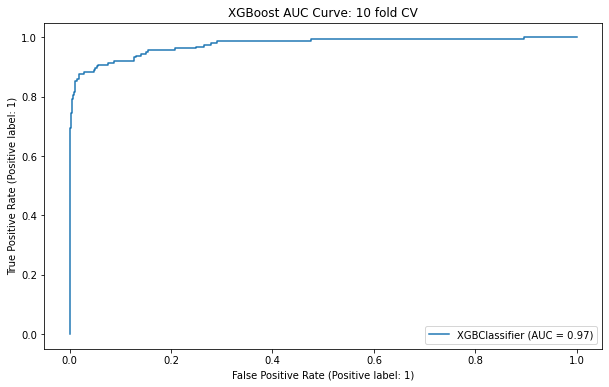

In [21]:
auc = metrics.roc_auc_score(y_test_10fold, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp = plot_roc_curve(model_10f_a, X_test_10fold, y_test_10fold)
title = "XGBoost AUC Curve: 10 fold CV"
disp.ax_.set_title(title)

plt.savefig(path + "/output/XGBoost_10f_a_AUC.png", bbox_inches='tight')
plt.show()

In [22]:
fmeasure = metrics.f1_score(y_test_10fold, predictions)
print("F-measure: %.2f%%" % (fmeasure * 100.0))

F-measure: 86.96%


In [23]:
precision = metrics.precision_score(y_test_10fold, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

Precision: 88.61%


In [24]:
recall = metrics.recall_score(y_test_10fold, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 85.37%


XGBoost Confusion matrix: 10 fold CV
[[1608   18]
 [  24  140]]


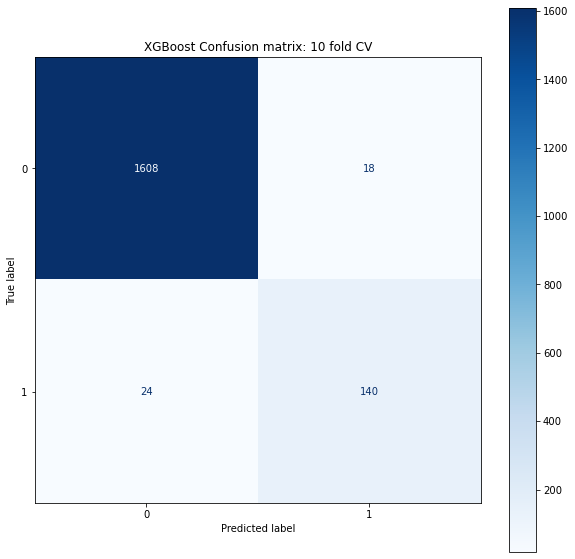

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test_10fold, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]

disp = plot_confusion_matrix(model_10f_a, X_test_10fold, y_test_10fold,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: 10 fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/XGBoost_10f_a_Confusion.png", bbox_inches='tight')
plt.show()

In [26]:
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Specificity: 98.89%


In [27]:
fpr = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr * 100.0))

False Positive Rate: 1.11%


In [28]:
g_mean = math.sqrt(precision*recall)
print("G-mean: %.2f%%" % (g_mean * 100.0))

G-mean: 86.97%


In [287]:
metrics_df = metrics_df.append(pd.DataFrame([['10 Fold CV', 'XGBoost', g_mean, fmeasure, recall, precision, specificity, fpr, accuracy, auc]], 
                          columns=['Split', 'Algorithm', 'G-Mean', 'F-Score', 
                                    'Recall', 'Precision', 'Specificity', 'FPR', 'Accuracy', 'AUC']), ignore_index=True)

print(metrics_df)

        Split Algorithm    G-Mean   F-Score    Recall  Precision  Specificity  \
0       Lyons   XGBoost  0.862534  0.862526  0.858930   0.866153     0.988106   
1  10 Fold CV   XGBoost  0.869716  0.869565  0.853659   0.886076     0.988930   

        FPR  Accuracy       AUC  
0  0.011894  0.977482  0.923518  
1  0.011070  0.976536  0.921294  


In [17]:
positive_train_our_split = confirmed_pulsar.iloc[:1000]
negative_train_our_split = confirmed_noise.iloc[:1000]
positive_test_our_split = confirmed_pulsar.iloc[1000:]
negative_test_our_split = confirmed_noise.iloc[1000:]

train_our_split = pd.concat([positive_train_our_split, negative_train_our_split],
                               ignore_index=True, sort=False)
test_our_split = pd.concat([positive_test_our_split, negative_test_our_split],
                               ignore_index=True, sort=False)

train_our_split = train_our_split.sample(frac=1).reset_index(drop=True)
test_our_split = test_our_split.sample(frac=1).reset_index(drop=True)

X_train_our_split = train_our_split.iloc[:, :8]
X_test_our_split = test_our_split.iloc[:, :8]
y_train_our_split = train_our_split.iloc[:, 8]
y_test_our_split = test_our_split.iloc[:, 8]

print(X_train_our_split.shape)
print(X_train_our_split.head())
print(X_test_our_split.shape)
print(X_test_our_split.head())
print(y_train_our_split.shape)
print(y_train_our_split.head())
print(y_test_our_split.shape)
print(y_test_our_split.head())

(2000, 8)
      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  130.304688    51.337815       0.070260    -0.182524   14.100334   
1  147.523438    52.398856      -0.440764    -0.210694   79.328595   
2   70.742188    44.612787       1.474643     2.703270  139.045151   
3   76.218750    46.775718       1.133907     1.858365   50.635452   
4   91.687500    45.699896       0.560430     0.766810    3.421405   

   standDev_DMSNR  excessKurt_DMSNR  skewness_DMSNR  
0       47.056324          3.343950       10.094273  
1       93.943998          0.481280       -1.551990  
2       84.470135         -0.821682       -0.956543  
3       77.106424          1.185711       -0.176323  
4       20.820896          6.794226       50.155050  
(15897, 8)
      mean_IP  standDev_IP  excessKurt_IP  skewness_IP  mean_DMSNR  \
0  139.929688    48.026227      -0.187779    -0.125530    2.446488   
1  120.625000    50.705954       0.212222    -0.134331    4.682274   
2   56.289062    34.8748

In [579]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5], 
        'scale_pos_weight': [0.1, 0.5, 1]
        }

skf =  model_selection.StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid =  model_selection.GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train_our_split, y_train_our_split), verbose=3)

startTrain = timer()
model_os = grid.fit(X_train_our_split, y_train_our_split)
endTrain = timer()

print(endTrain -  startTrain)

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
2405.6386677180126


In [580]:
print(grid.best_params_)

{'colsample_bytree': 1.0, 'gamma': 2, 'max_depth': 4, 'min_child_weight': 5, 'scale_pos_weight': 1, 'subsample': 1.0}


In [581]:
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=4, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [582]:
y_pred = model_os.predict(X_test_our_split)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_our_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.68%


In [583]:
auc = metrics.roc_auc_score(y_test_our_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

auc: 95.05%


Confusion matrix
[[14608   650]
 [   36   603]]


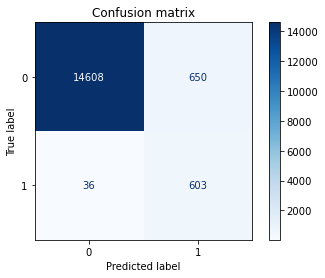

In [584]:
disp = plot_confusion_matrix(model_os, X_test_our_split, y_test_our_split,
                                 cmap=plt.cm.Blues)
title = "Confusion matrix"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

In [18]:
xgb = XGBClassifier(colsample_bytree=1.0, gamma=1.5, max_depth=3, 
                    min_child_weight=1, scale_pos_weight=0.1, 
                    learning_rate=0.02, n_estimators=600, 
                    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

startTrain = timer()
model_os_a = xgb.fit(X_train_our_split, y_train_our_split)
endTrain = timer()

print(endTrain -  startTrain)

0.5154626400000097


In [19]:
y_pred = model_os_a.predict(X_test_our_split)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_our_split, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.72%


auc: 92.28%


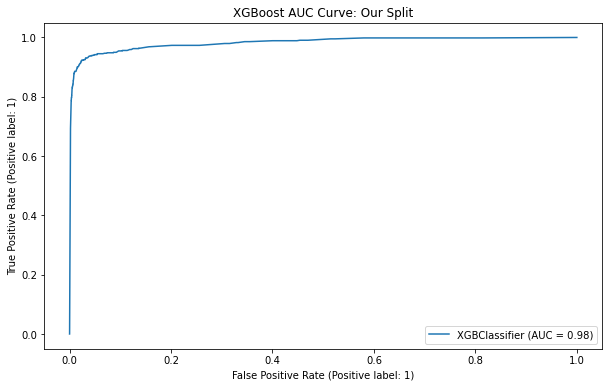

In [20]:
auc = metrics.roc_auc_score(y_test_our_split, predictions)
print("auc: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp = plot_roc_curve(model_os_a, X_test_our_split, y_test_our_split)
title = "XGBoost AUC Curve: Our Split"
disp.ax_.set_title(title)

plt.savefig(path + "/output/XGBoost_os_a_AUC.png", bbox_inches='tight')
plt.show()

In [33]:
fmeasure = metrics.f1_score(y_test_our_split, predictions)
print("F-measure: %.2f%%" % (fmeasure * 100.0))

F-measure: 84.23%


In [34]:
precision = metrics.precision_score(y_test_our_split, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

Precision: 83.21%


In [35]:
recall = metrics.recall_score(y_test_our_split, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 85.29%


XGBoost Confusion matrix: Our Split
[[15148   110]
 [   94   545]]


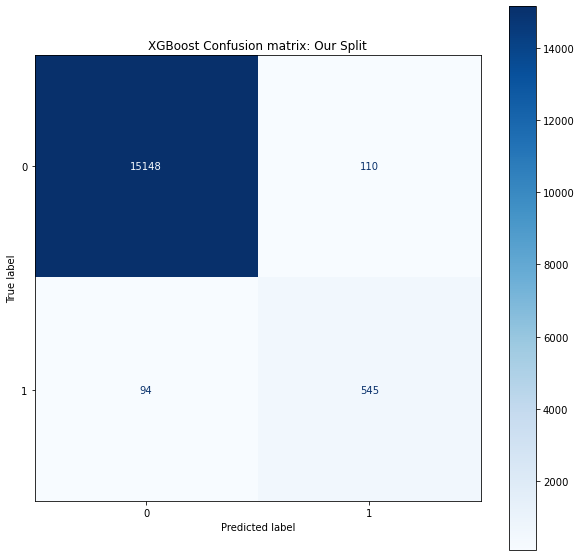

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test_our_split, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]

disp = plot_confusion_matrix(model_os_a, X_test_our_split, y_test_our_split,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: Our Split"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/XGBoost_os_a_Confusion.png", bbox_inches='tight')
plt.show()

In [37]:
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Specificity: 99.28%


In [38]:
fpr = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr * 100.0))

False Positive Rate: 0.72%


In [39]:
g_mean = math.sqrt(precision*recall)
print("G-mean: %.2f%%" % (g_mean * 100.0))

G-mean: 84.24%


In [297]:
metrics_df = metrics_df.append(pd.DataFrame([['Group', 'XGBoost', g_mean, fmeasure, recall, precision, specificity, fpr, accuracy, auc]], 
                          columns=['Split', 'Algorithm', 'G-Mean', 'F-Score', 
                                    'Recall', 'Precision', 'Specificity', 'FPR', 'Accuracy', 'AUC']), ignore_index=True)

print(metrics_df)

        Split Algorithm    G-Mean   F-Score    Recall  Precision  Specificity  \
0       Lyons   XGBoost  0.862534  0.862526  0.858930   0.866153     0.988106   
1  10 Fold CV   XGBoost  0.869716  0.869565  0.853659   0.886076     0.988930   
2       Group   XGBoost  0.842414  0.842349  0.852895   0.832061     0.992791   

        FPR  Accuracy       AUC  
0  0.011894  0.977482  0.923518  
1  0.011070  0.976536  0.921294  
2  0.007209  0.987167  0.922843  


In [21]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='logloss',
              gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=5, min_child_weight=5,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

model_5f_a = xgb.fit(X_train_5fold, y_train_5fold)

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=3, min_child_weight=10,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

model_3f_a = xgb.fit(X_train_3fold, y_train_3fold)

In [22]:
y_pred = model_3f_a.predict(X_test_3fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_3fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.92%


AUC: 93.45%


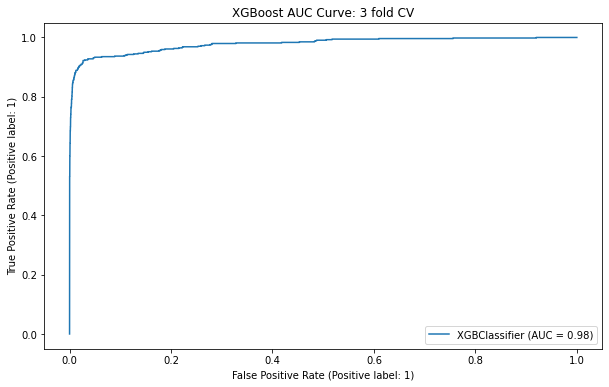

In [23]:
auc = metrics.roc_auc_score(y_test_3fold, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp = plot_roc_curve(model_3f_a, X_test_3fold, y_test_3fold)
title = "XGBoost AUC Curve: 3 fold CV"
disp.ax_.set_title(title)

plt.savefig(path + "/output/XGBoost_3f_a_AUC.png", bbox_inches='tight')
plt.show()

In [24]:
fmeasure = metrics.f1_score(y_test_3fold, predictions)
print("F-measure: %.2f%%" % (fmeasure * 100.0))

F-measure: 88.56%


In [25]:
precision = metrics.precision_score(y_test_3fold, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

Precision: 89.14%


In [45]:
recall = metrics.recall_score(y_test_3fold, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 87.99%


XGBoost Confusion matrix: 3 Fold CV
[[5308   58]
 [  65  476]]


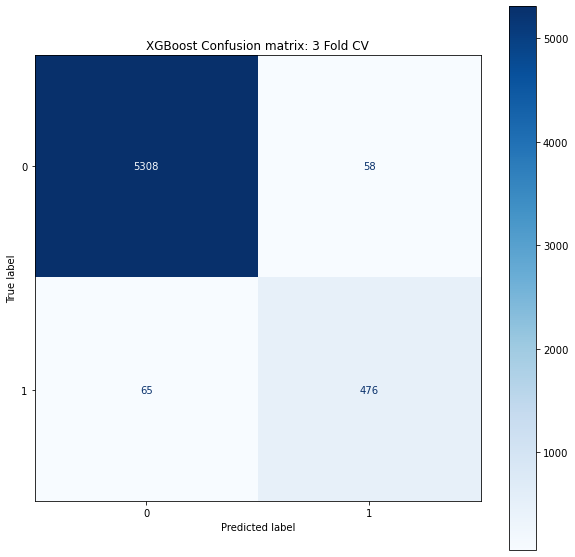

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test_3fold, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]

disp = plot_confusion_matrix(model_3f_a, X_test_3fold, y_test_3fold,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: 3 Fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/XGBoost_3f_a_Confusion.png", bbox_inches='tight')
plt.show()

In [47]:
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Specificity: 98.92%


In [48]:
fpr = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr * 100.0))

False Positive Rate: 1.08%


In [49]:
g_mean = math.sqrt(precision*recall)
print("G-mean: %.2f%%" % (g_mean * 100.0))

G-mean: 88.56%


In [307]:
metrics_df = metrics_df.append(pd.DataFrame([['3 Fold CV', 'XGBoost', g_mean, fmeasure, recall, precision, specificity, fpr, accuracy, auc]], 
                          columns=['Split', 'Algorithm', 'G-Mean', 'F-Score', 
                                    'Recall', 'Precision', 'Specificity', 'FPR', 'Accuracy', 'AUC']), ignore_index=True)

print(metrics_df)

        Split Algorithm    G-Mean   F-Score    Recall  Precision  Specificity  \
0       Lyons   XGBoost  0.862534  0.862526  0.858930   0.866153     0.988106   
1  10 Fold CV   XGBoost  0.869716  0.869565  0.853659   0.886076     0.988930   
2       Group   XGBoost  0.842414  0.842349  0.852895   0.832061     0.992791   
3   3 Fold CV   XGBoost  0.885600  0.885581  0.879852   0.891386     0.989191   

        FPR  Accuracy       AUC  
0  0.011894  0.977482  0.923518  
1  0.011070  0.976536  0.921294  
2  0.007209  0.987167  0.922843  
3  0.010809  0.979177  0.934522  


In [26]:
y_pred = model_5f_a.predict(X_test_5fold)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test_5fold, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.74%


AUC: 93.13%


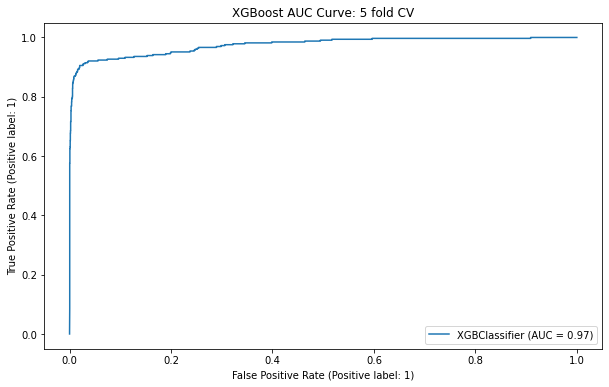

In [27]:
auc = metrics.roc_auc_score(y_test_5fold, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp = plot_roc_curve(model_5f_a, X_test_5fold, y_test_5fold)
title = "XGBoost AUC Curve: 5 fold CV"
disp.ax_.set_title(title)

plt.savefig(path + "/output/XGBoost_5f_a_AUC.png", bbox_inches='tight')
plt.show()

In [52]:
fmeasure = metrics.f1_score(y_test_5fold, predictions)
print("F-measure: %.2f%%" % (fmeasure * 100.0))

F-measure: 87.63%


In [53]:
precision = metrics.precision_score(y_test_5fold, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

Precision: 87.77%


In [54]:
recall = metrics.recall_score(y_test_5fold, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

Recall: 87.50%


XGBoost Confusion matrix: 5 Fold CV
[[3212   40]
 [  41  287]]


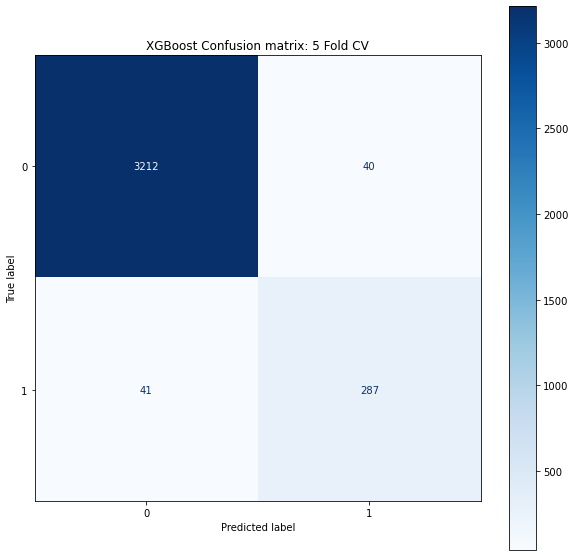

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test_5fold, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]

disp = plot_confusion_matrix(model_5f_a, X_test_5fold, y_test_5fold,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: 5 Fold CV"
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.savefig(path + "/output/XGBoost_5f_a_Confusion.png", bbox_inches='tight')
plt.show()

In [56]:
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Specificity: 98.77%


In [57]:
fpr = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr * 100.0))

False Positive Rate: 1.23%


In [58]:
g_mean = math.sqrt(precision*recall)
print("G-mean: %.2f%%" % (g_mean * 100.0))

G-mean: 87.63%


In [317]:
metrics_df = metrics_df.append(pd.DataFrame([['5 Fold CV', 'XGBoost', g_mean, fmeasure, recall, precision, specificity, fpr, accuracy, auc]], 
                          columns=['Split', 'Algorithm', 'G-Mean', 'F-Score', 
                                    'Recall', 'Precision', 'Specificity', 'FPR', 'Accuracy', 'AUC']), ignore_index=True)

print(metrics_df)
metrics_df.to_csv(path + "/output/XGBoost_metrics.csv")

        Split Algorithm    G-Mean   F-Score    Recall  Precision  Specificity  \
0       Lyons   XGBoost  0.862534  0.862526  0.858930   0.866153     0.988106   
1  10 Fold CV   XGBoost  0.869716  0.869565  0.853659   0.886076     0.988930   
2       Group   XGBoost  0.842414  0.842349  0.852895   0.832061     0.992791   
3   3 Fold CV   XGBoost  0.885600  0.885581  0.879852   0.891386     0.989191   
4   5 Fold CV   XGBoost  0.876337  0.876336  0.875000   0.877676     0.987700   

        FPR  Accuracy       AUC  
0  0.011894  0.977482  0.923518  
1  0.011070  0.976536  0.921294  
2  0.007209  0.987167  0.922843  
3  0.010809  0.979177  0.934522  
4  0.012300  0.977374  0.931350  


In [318]:
joblib_file = "model_ps_a.pkl"
joblib.dump(model_ps_a, joblib_file)

joblib_file = "model_3f_a.pkl"
joblib.dump(model_10f_a, joblib_file)

joblib_file = "model_5f_a.pkl"
joblib.dump(model_10f_a, joblib_file)

joblib_file = "model_10f_a.pkl"
joblib.dump(model_10f_a, joblib_file)

joblib_file = "model_os_a.pkl"
joblib.dump(model_os_a, joblib_file)

['model_os_a.pkl']

 99%|===================| 17705/17897 [00:22<00:00]        

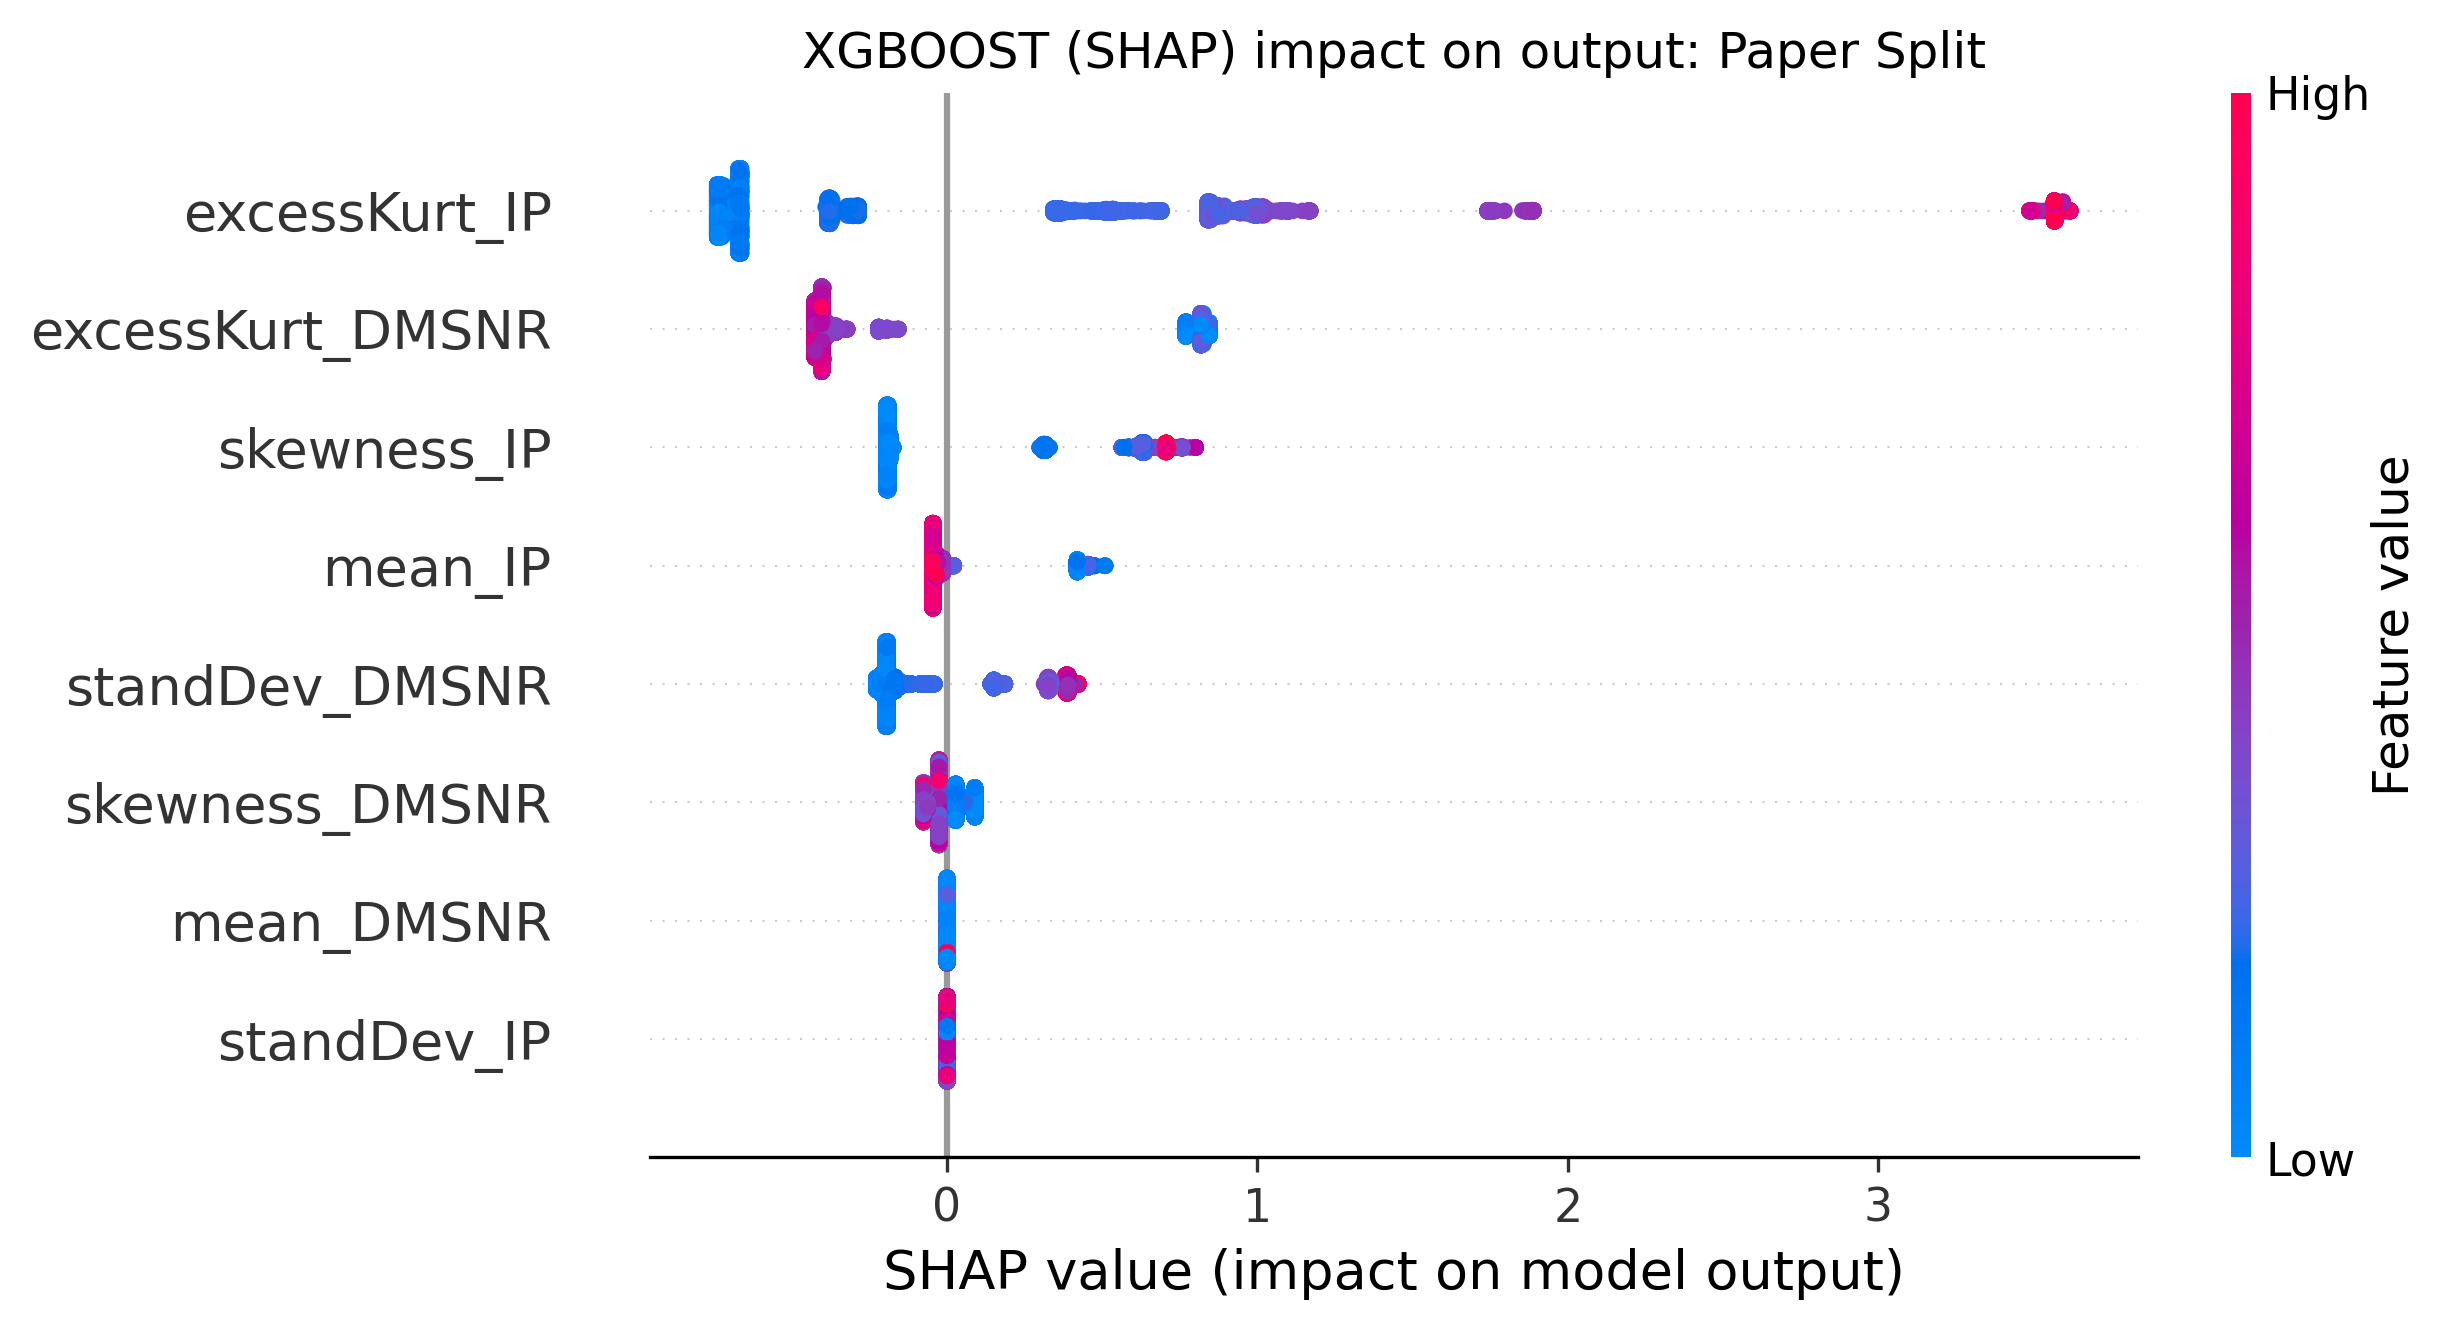

In [319]:
explainer = sh.TreeExplainer(model_ps_a, X)

shap_values = explainer(X)
plt.figure(num=None, figsize=(8, 6), dpi=300)
plt.yticks(fontsize=16)
plt.title("XGBOOST (SHAP) impact on output: Paper Split")

sh.plots.beeswarm(
                    shap_values = shap_values,
                    max_display = 11,  
                    order = shap_values.abs.max(0), show=False                                     
                 )

plt.savefig(path + "/output/XGBoost_ps_a_VariableImportance.png", bbox_inches='tight')
plt.show()

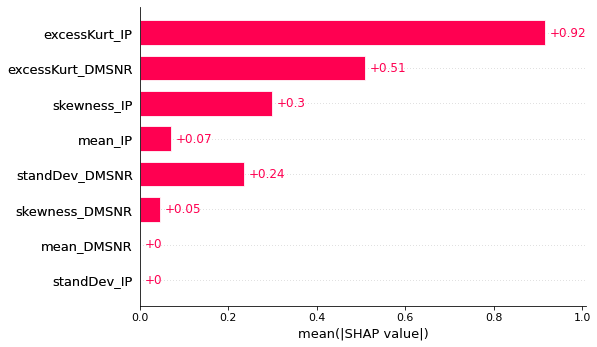

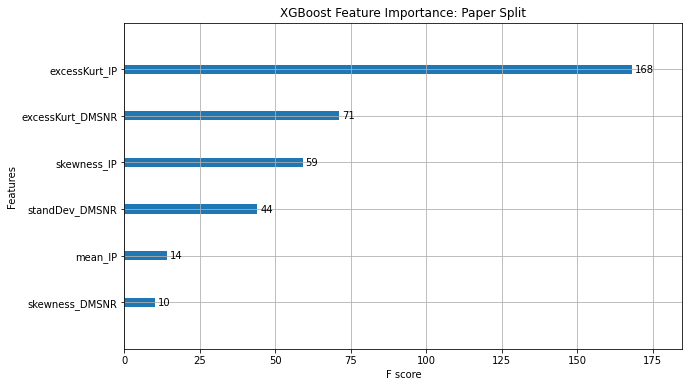

In [320]:
plt.rcParams['figure.figsize'] = [10, 6]
sh.plots.bar(
                shap_values = shap_values.abs.mean(0),
                max_display = 8,  
                order = shap_values.abs.max(0)             
            )

#Variable importance using SHAP package
plot_importance(
                    model_ps_a, 
                    max_num_features=8

                )
plt.title("XGBoost Feature Importance: Paper Split")
#Visualize Tree
plt.savefig(path + "/output/XGBoost_ps_a_barImportance.png", bbox_inches='tight')
plt.show()

 99%|===================| 17687/17897 [01:22<00:00]        

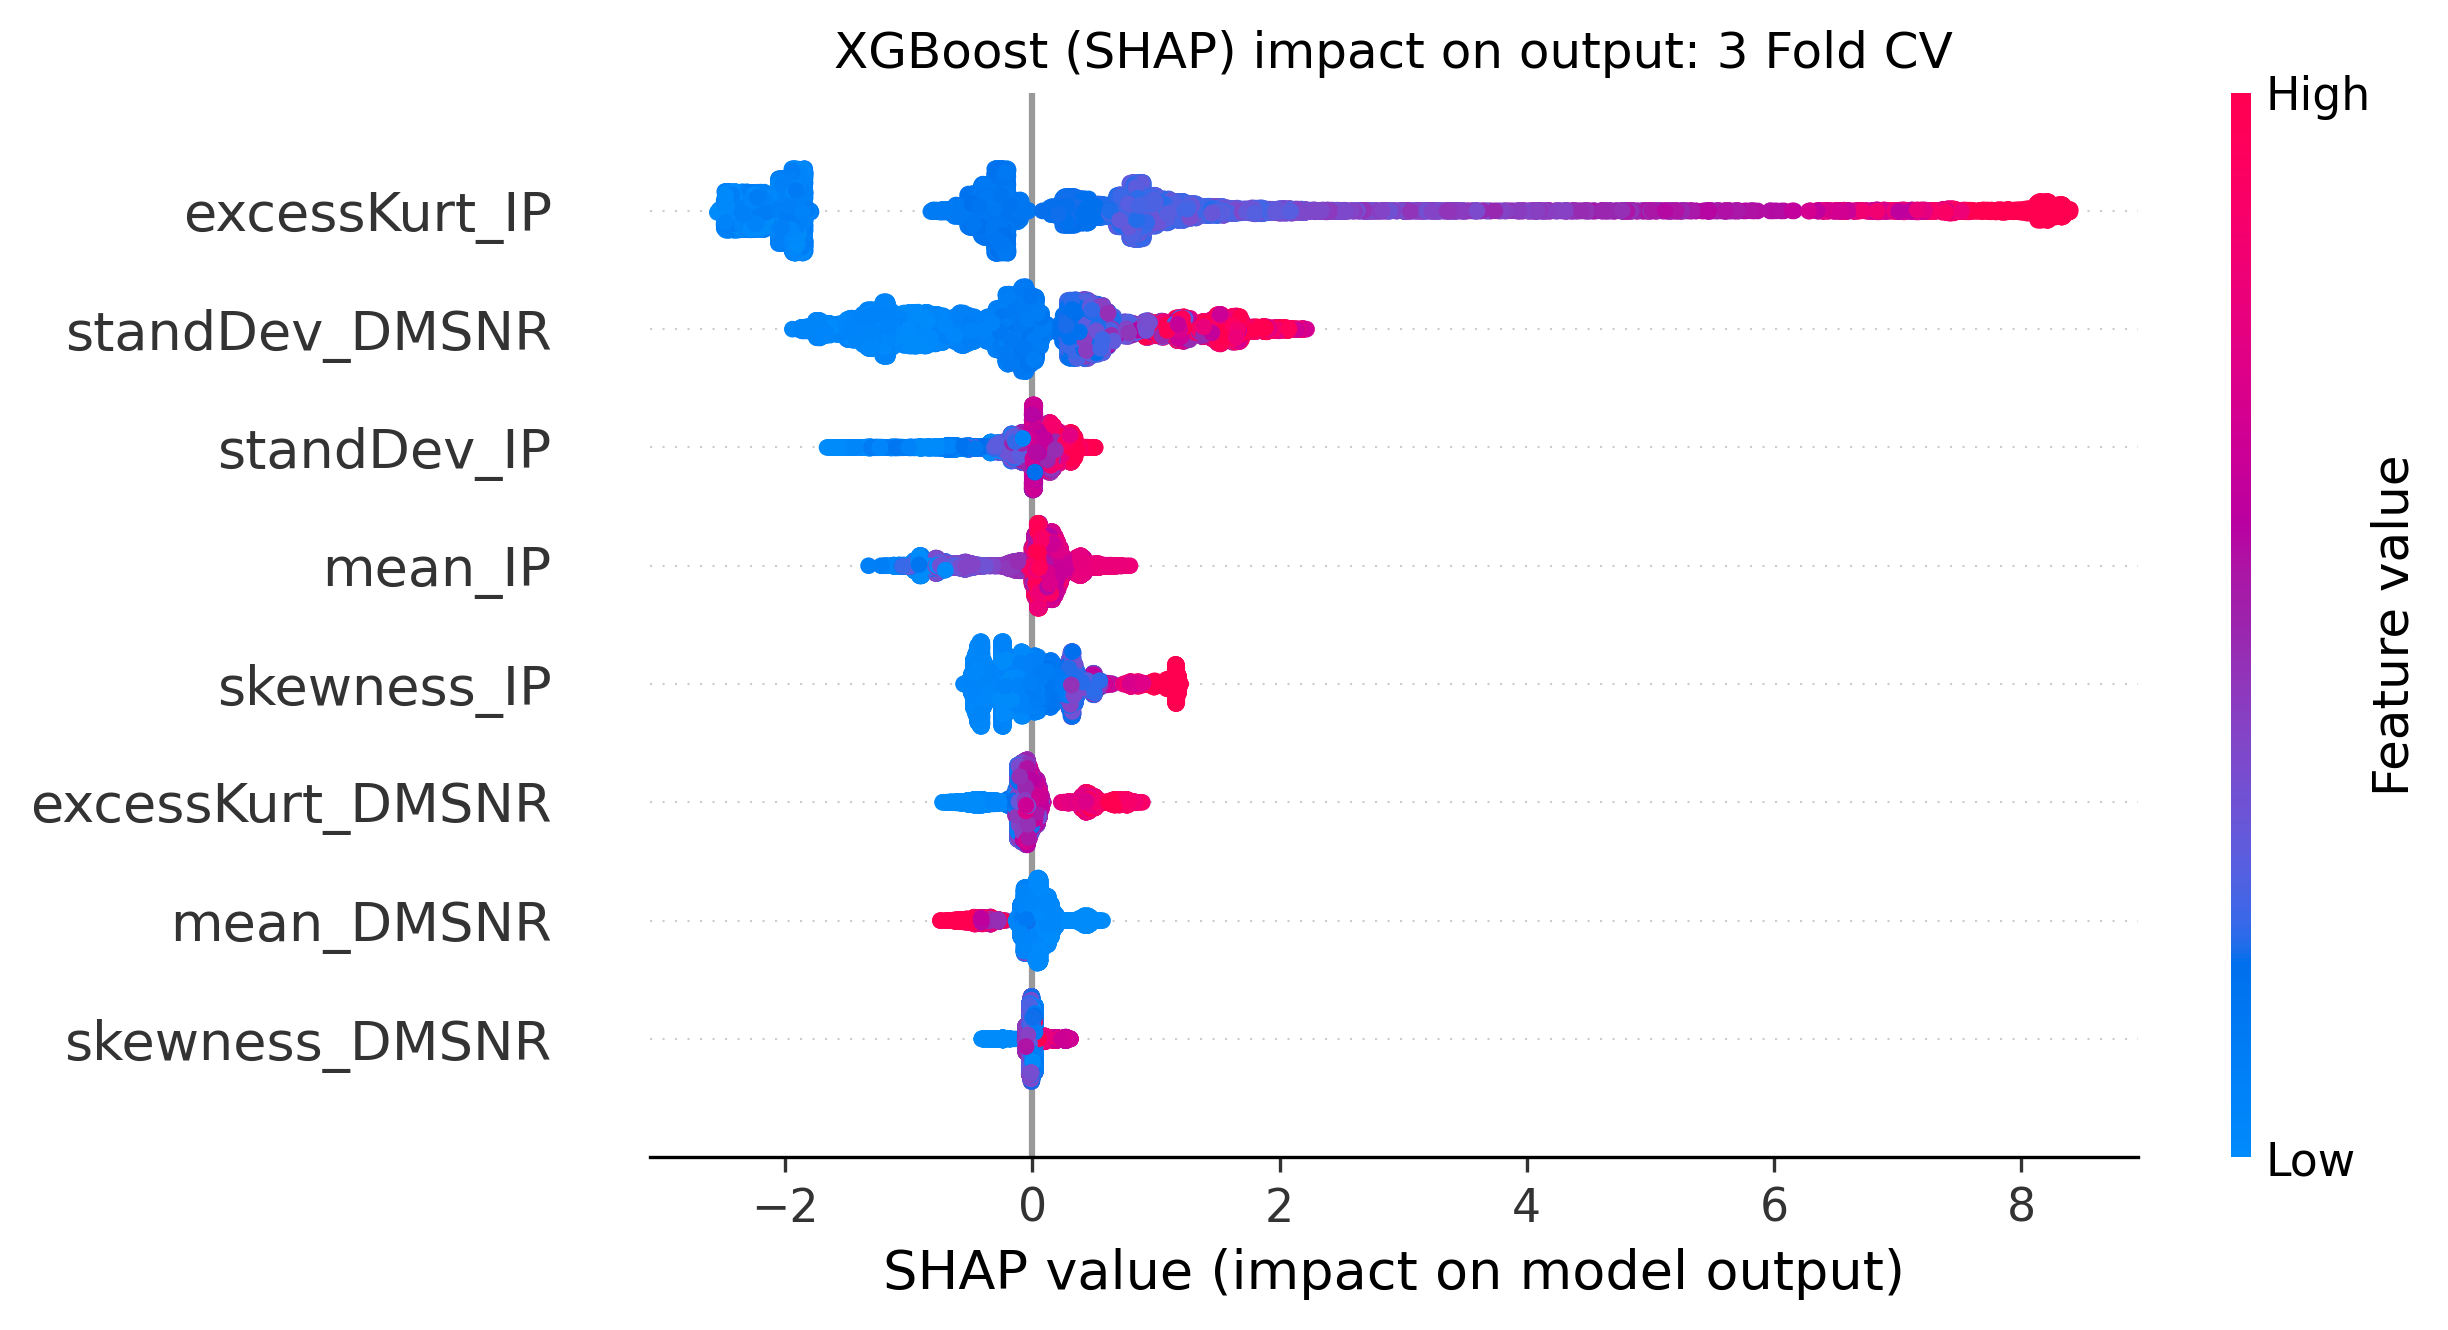

In [321]:
explainer = sh.TreeExplainer(model_3f_a, X)

shap_values = explainer(X)
plt.figure(num=None, figsize=(8, 6), dpi=300)
plt.yticks(fontsize=16)
plt.title("XGBoost (SHAP) impact on output: 3 Fold CV")

sh.plots.beeswarm(
                    shap_values = shap_values,
                    max_display = 11,  
                    order = shap_values.abs.max(0), show=False                                     
                 )

plt.savefig(path + "/output/XGBoost_3f_VariableImportance.png", bbox_inches='tight')
plt.show()

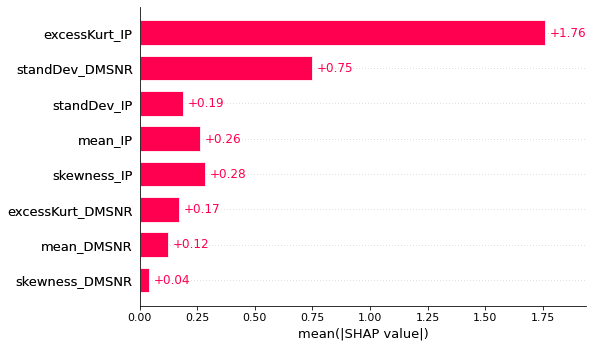

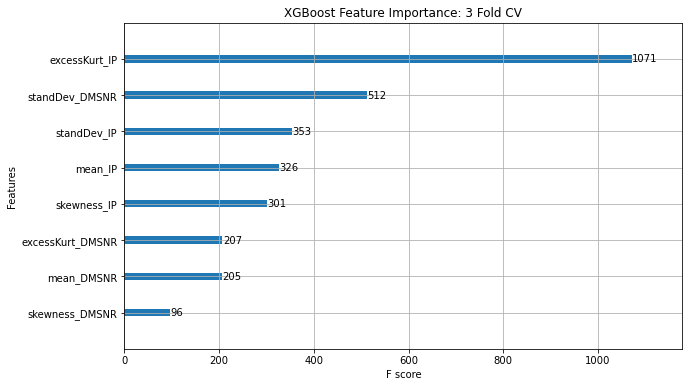

In [322]:
plt.rcParams['figure.figsize'] = [10, 6]
sh.plots.bar(
                shap_values = shap_values.abs.mean(0),
                max_display = 8,  
                order = shap_values.abs.max(0)             
            )

#Variable importance using SHAP package
plot_importance(
                    model_3f_a, 
                    max_num_features=8

                )
plt.title("XGBoost Feature Importance: 3 Fold CV")
#Visualize Tree
plt.savefig(path + "/output/XGBoost_3f_barImportance.png", bbox_inches='tight')
plt.show()

 99%|===================| 17744/17897 [01:36<00:00]        

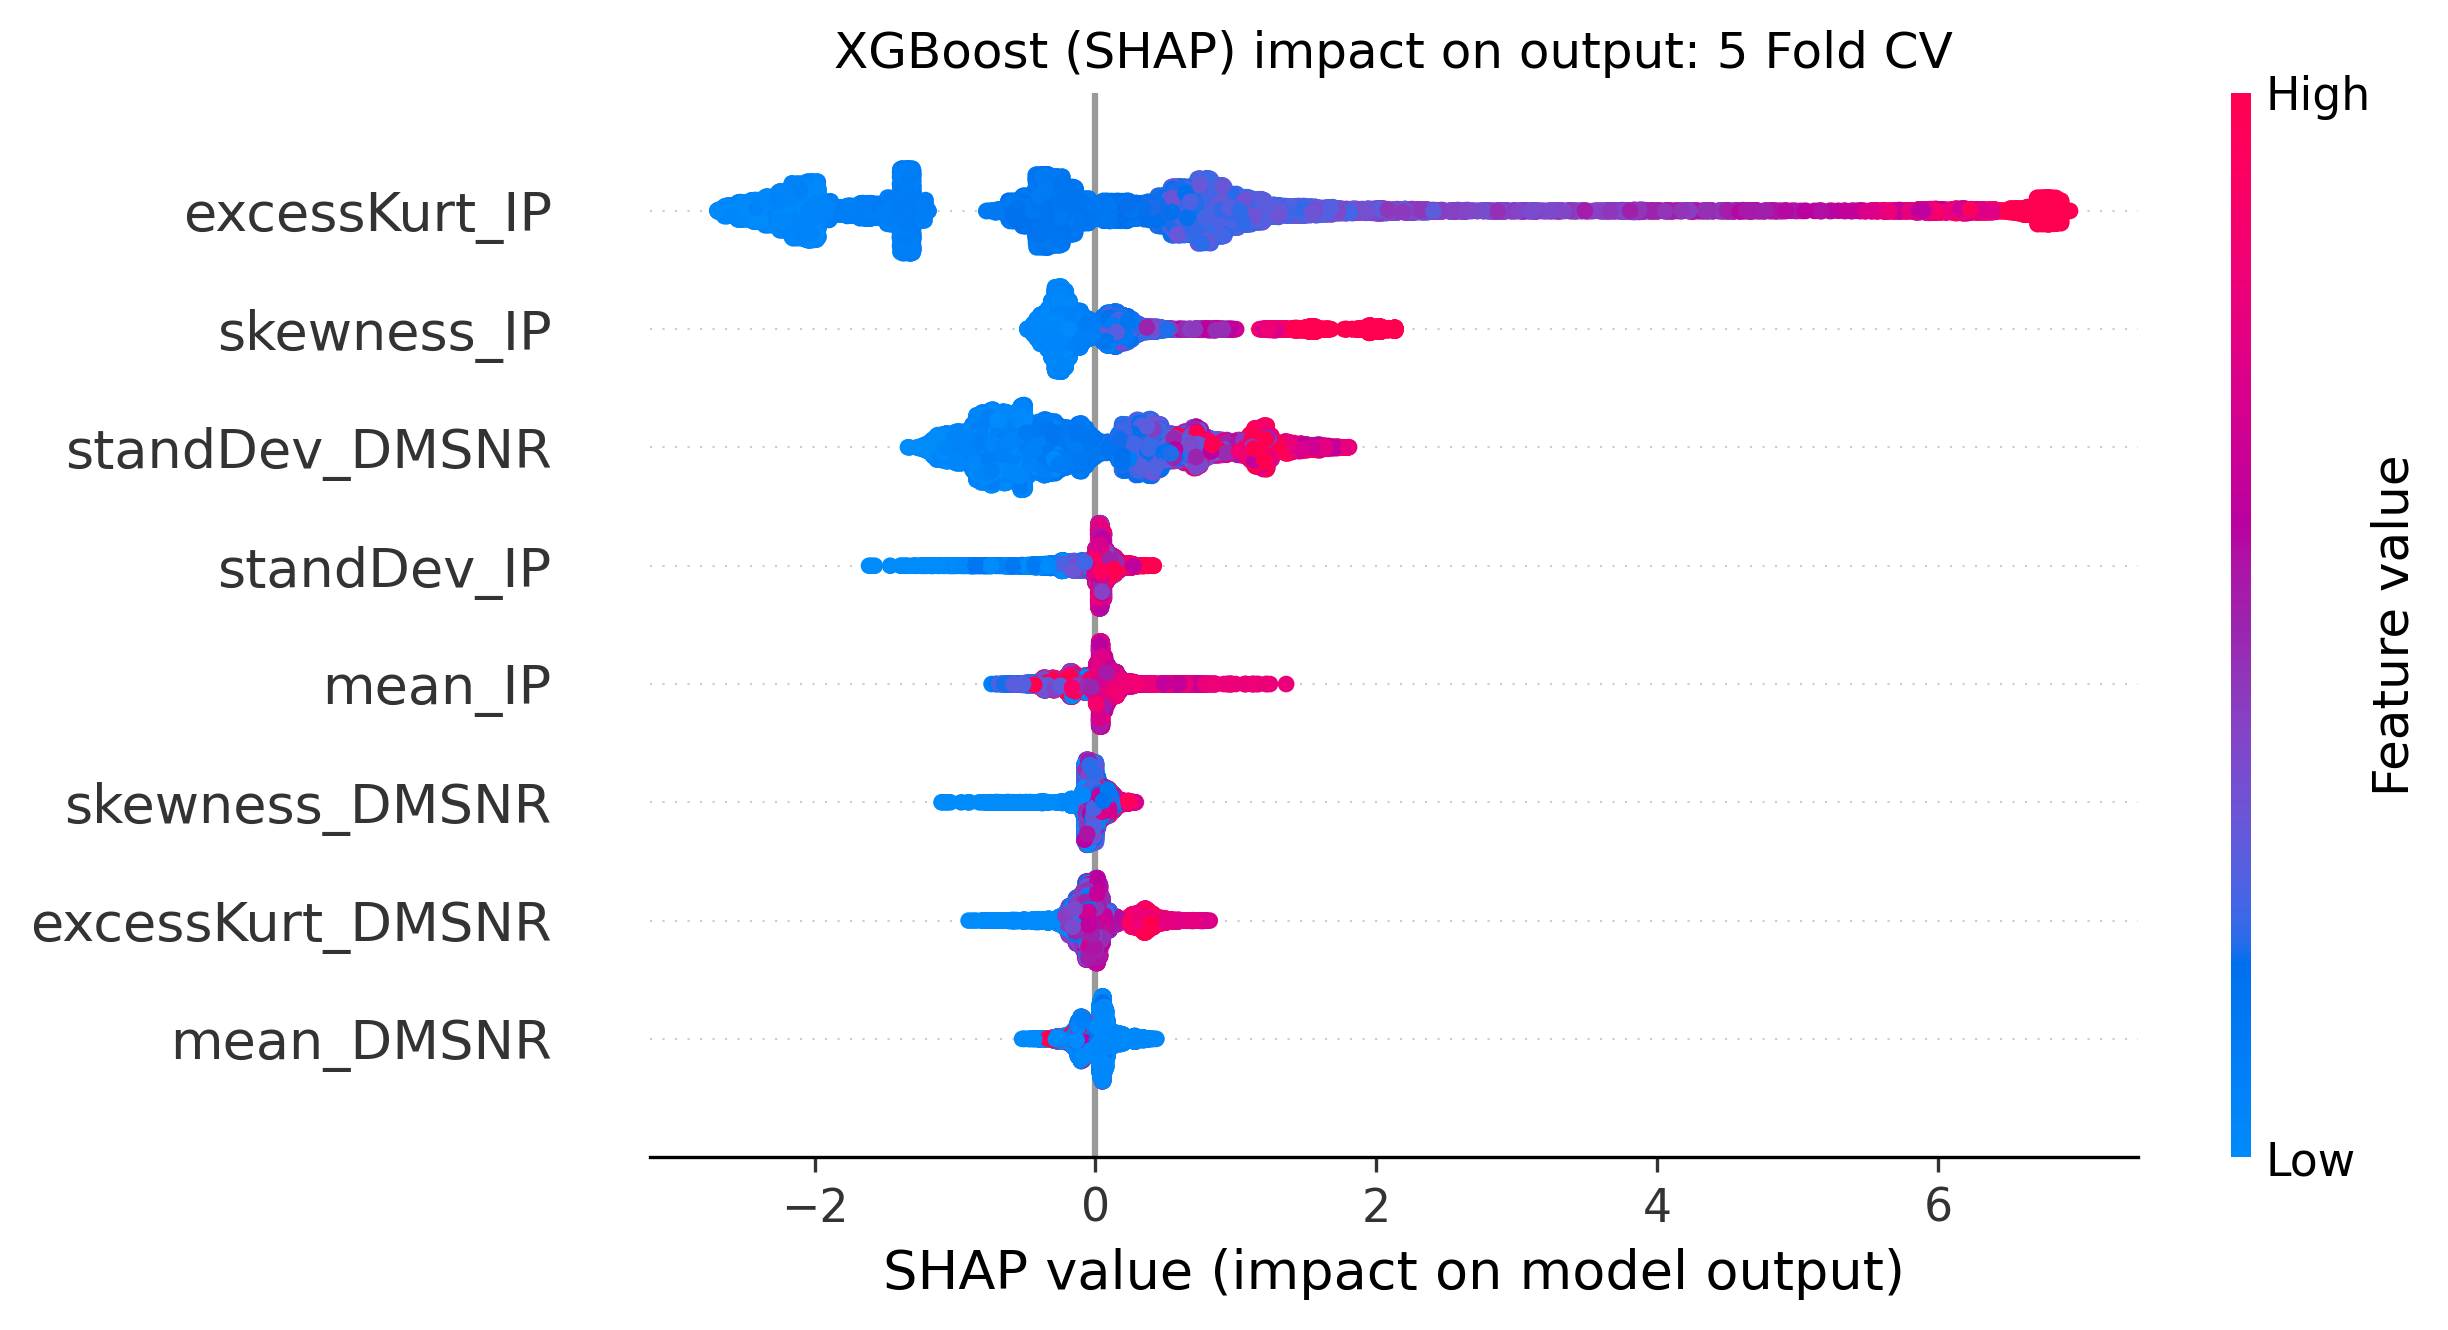

In [323]:
explainer = sh.TreeExplainer(model_5f_a, X)

shap_values = explainer(X)
plt.figure(num=None, figsize=(8, 6), dpi=300)
plt.yticks(fontsize=16)
plt.title("XGBoost (SHAP) impact on output: 5 Fold CV")

sh.plots.beeswarm(
                    shap_values = shap_values,
                    max_display = 11,  
                    order = shap_values.abs.max(0), show=False                                     
                 )

plt.savefig(path + "/output/XGBoost_5f_VariableImportance.png", bbox_inches='tight')
plt.show()

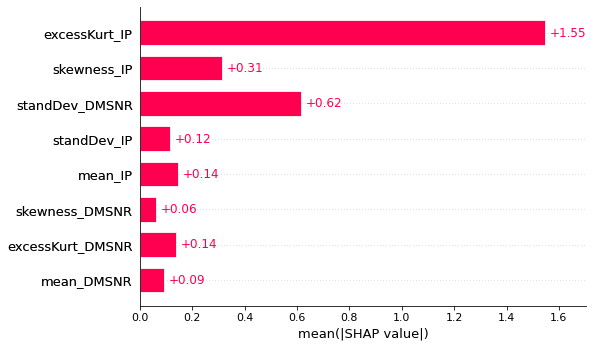

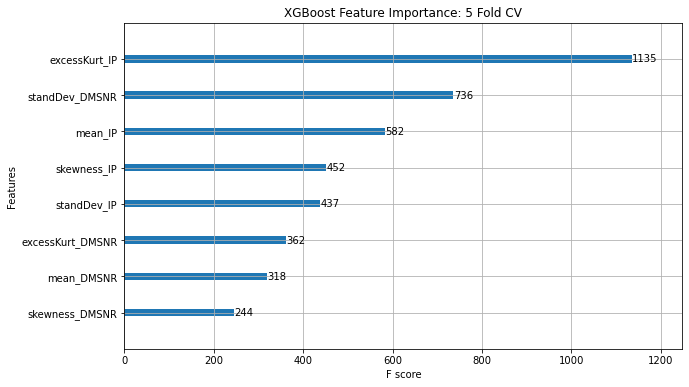

In [324]:
plt.rcParams['figure.figsize'] = [10, 6]
sh.plots.bar(
                shap_values = shap_values.abs.mean(0),
                max_display = 8,  
                order = shap_values.abs.max(0)             
            )

#Variable importance using SHAP package
plot_importance(
                    model_5f_a, 
                    max_num_features=8

                )
plt.title("XGBoost Feature Importance: 5 Fold CV")
#Visualize Tree
plt.savefig(path + "/output/XGBoost_5f_barImportance.png", bbox_inches='tight')
plt.show()

 99%|===================| 17691/17897 [01:15<00:00]        

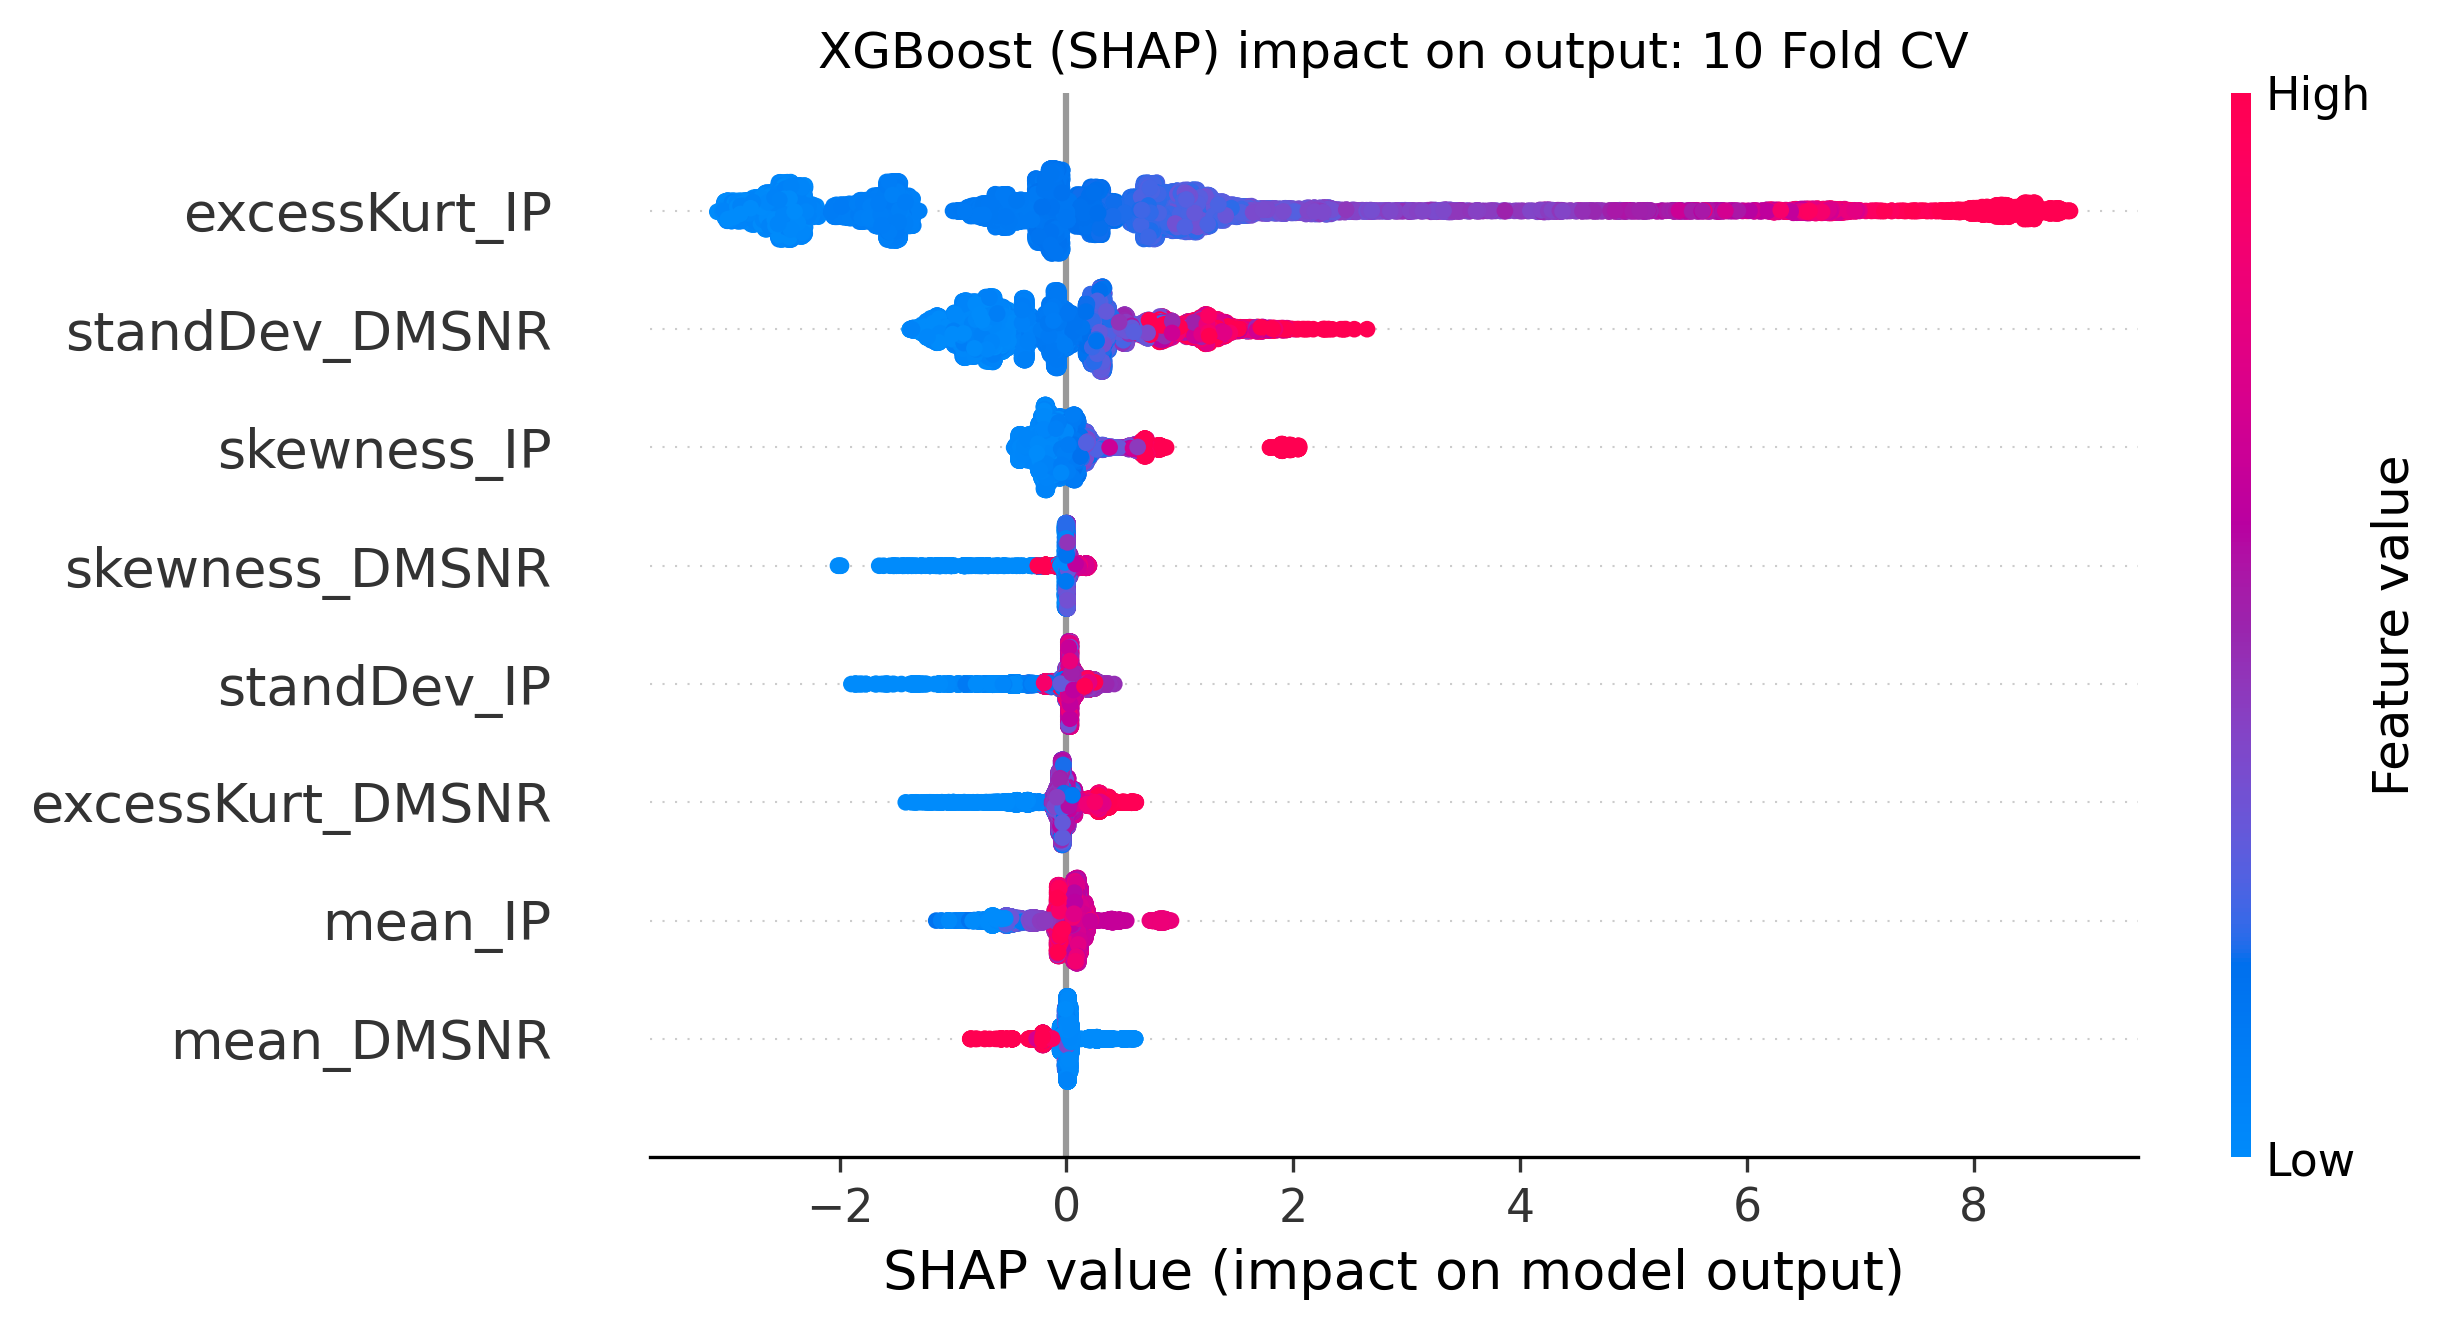

In [325]:
explainer = sh.TreeExplainer(model_10f_a, X)

shap_values = explainer(X)
plt.figure(num=None, figsize=(8, 6), dpi=300)
plt.yticks(fontsize=16)
plt.title("XGBoost (SHAP) impact on output: 10 Fold CV")

sh.plots.beeswarm(
                    shap_values = shap_values,
                    max_display = 11,  
                    order = shap_values.abs.max(0), show=False                                     
                 )

plt.savefig(path + "/output/XGBoost_10f_VariableImportance.png", bbox_inches='tight')
plt.show()

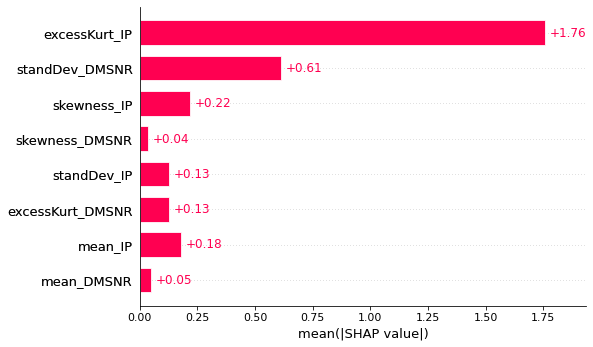

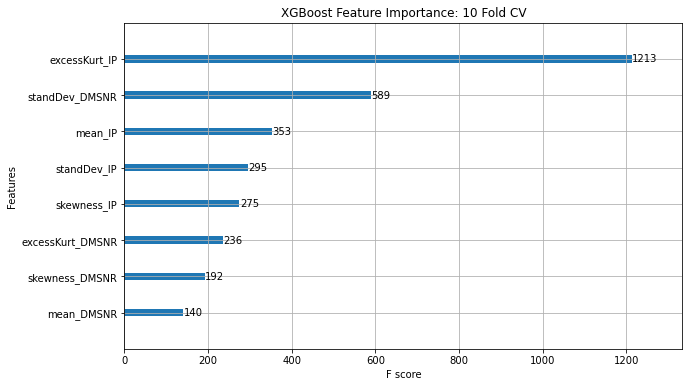

In [326]:
plt.rcParams['figure.figsize'] = [10, 6]
sh.plots.bar(
                shap_values = shap_values.abs.mean(0),
                max_display = 8,  
                order = shap_values.abs.max(0)             
            )

#Variable importance using SHAP package
plot_importance(
                    model_10f_a, 
                    max_num_features=8

                )
plt.title("XGBoost Feature Importance: 10 Fold CV")
#Visualize Tree
plt.savefig(path + "/output/XGBoost_10f_barImportance.png", bbox_inches='tight')
plt.show()

100%|===================| 17812/17897 [00:26<00:00]        

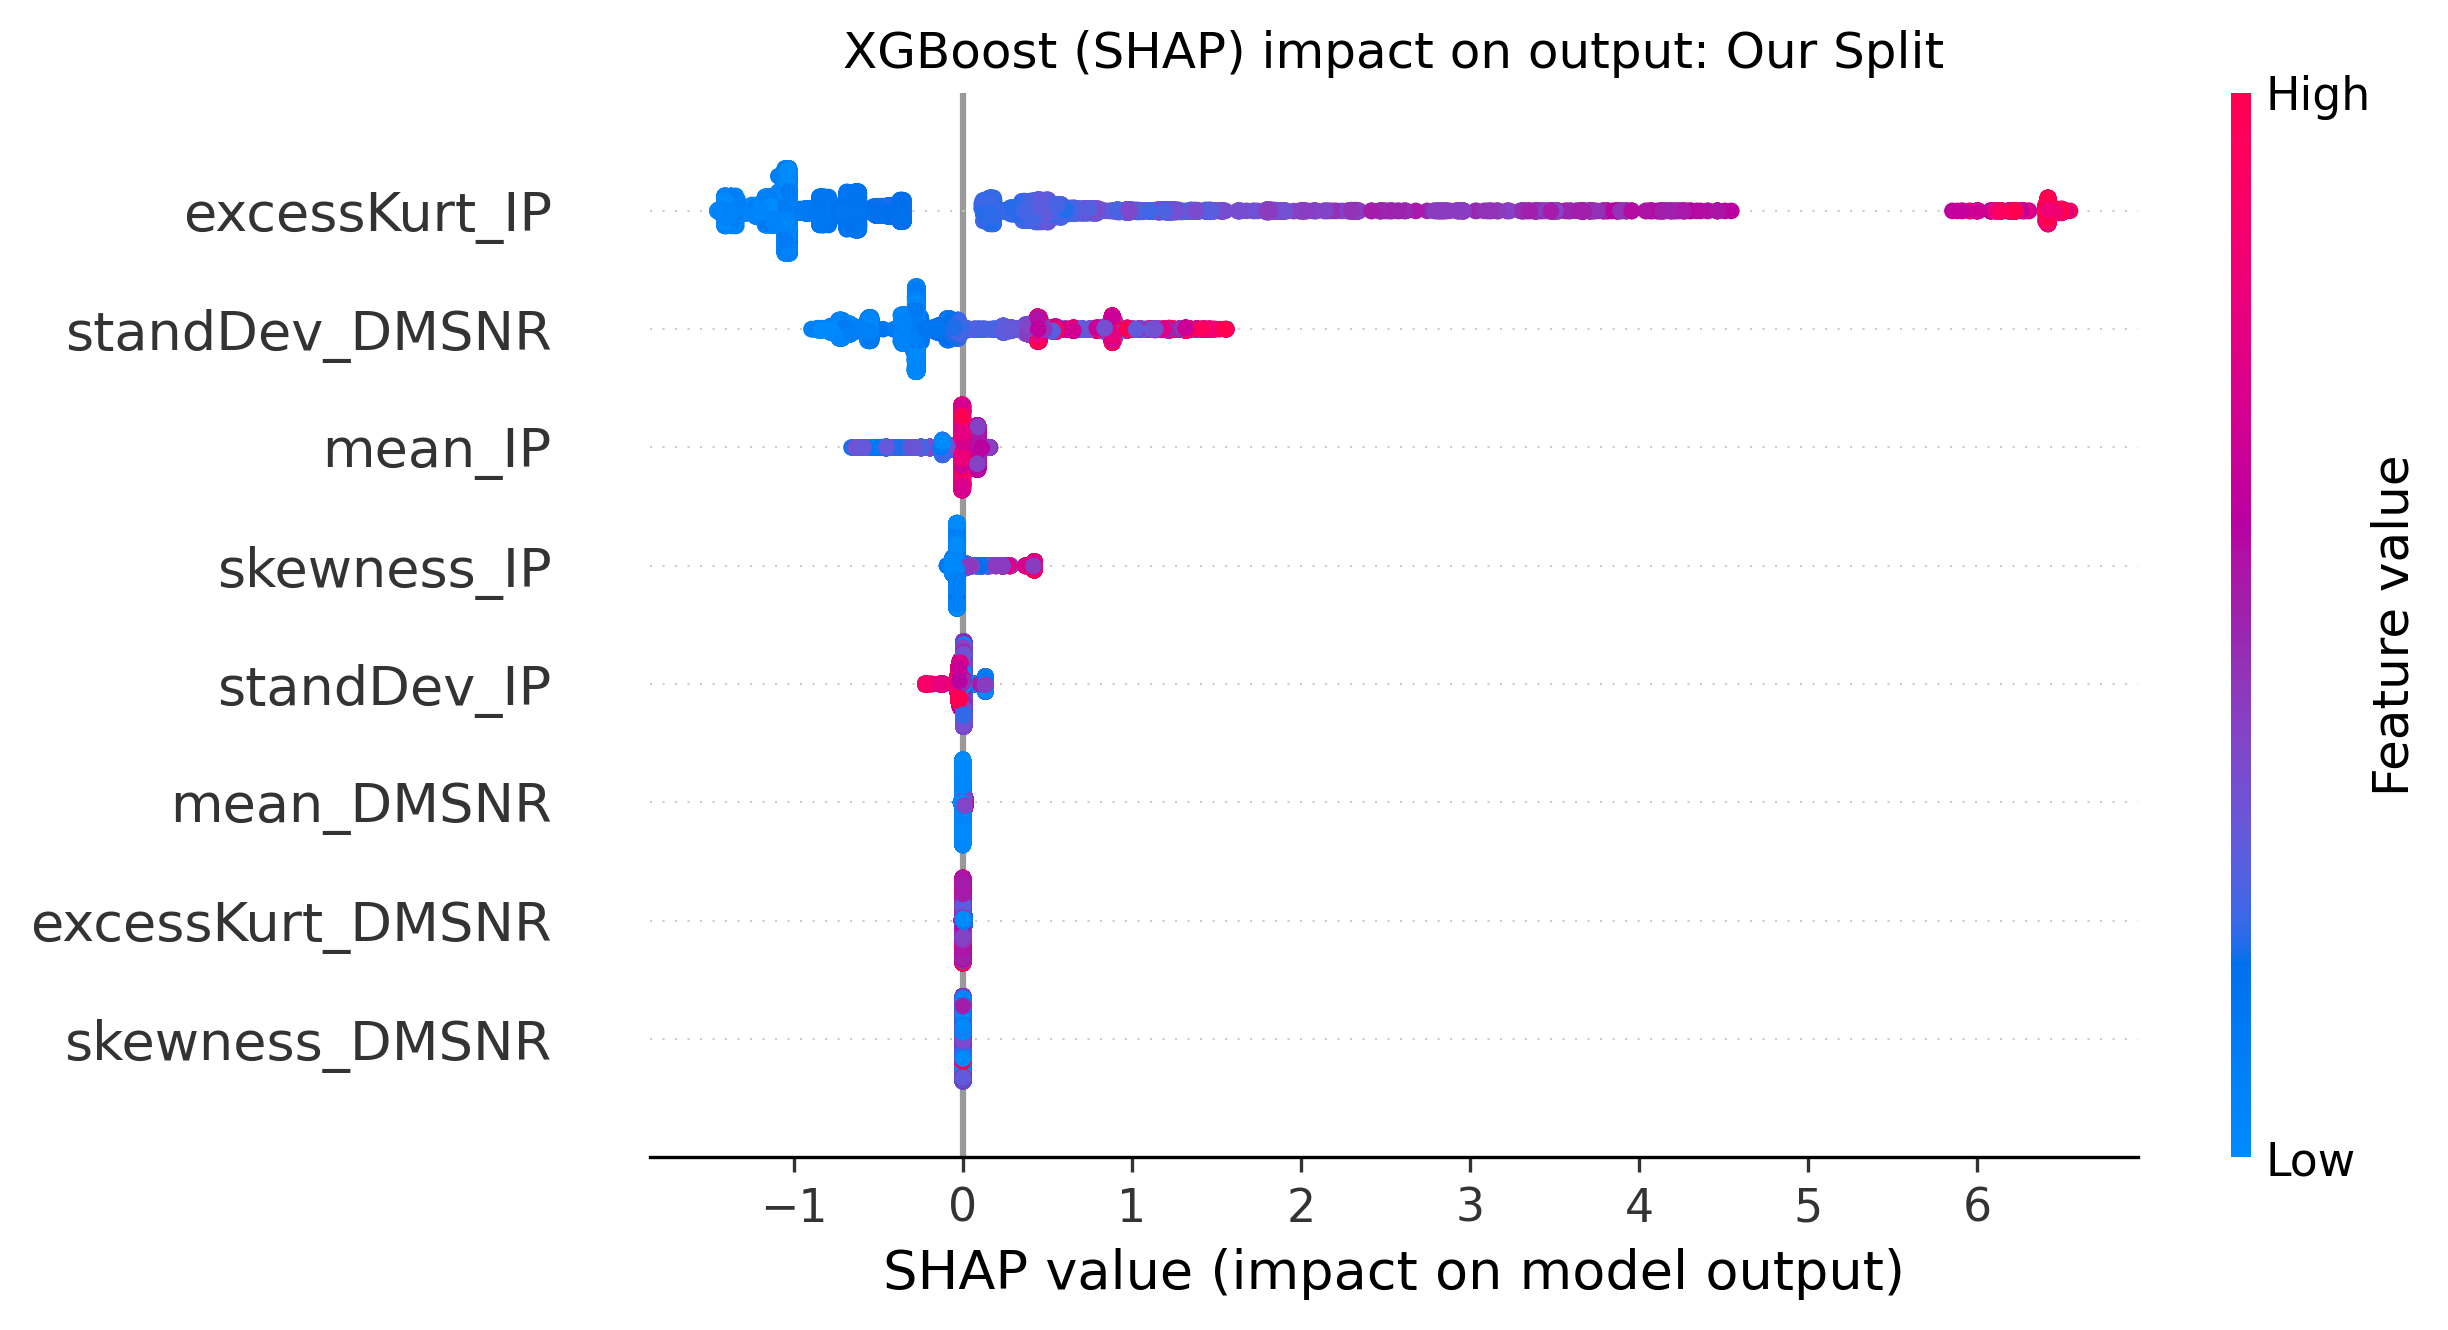

In [327]:
explainer = sh.TreeExplainer(model_os_a, X)

shap_values = explainer(X)
plt.figure(num=None, figsize=(8, 6), dpi=300)
plt.yticks(fontsize=16)
plt.title("XGBoost (SHAP) impact on output: Our Split")

sh.plots.beeswarm(
                    shap_values = shap_values,
                    max_display = 11,  
                    order = shap_values.abs.max(0), show=False                                     
                 )

plt.savefig(path + "/output/XGBoost_os_a_VariableImportance.png", bbox_inches='tight')
plt.show()

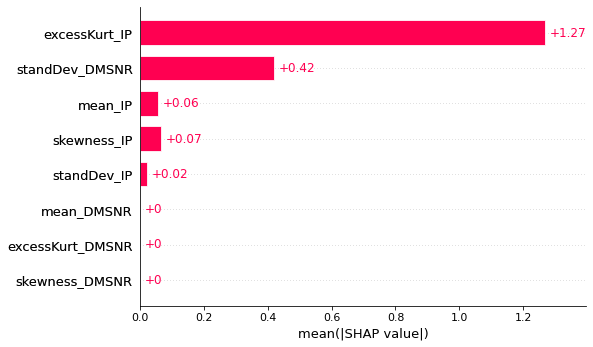

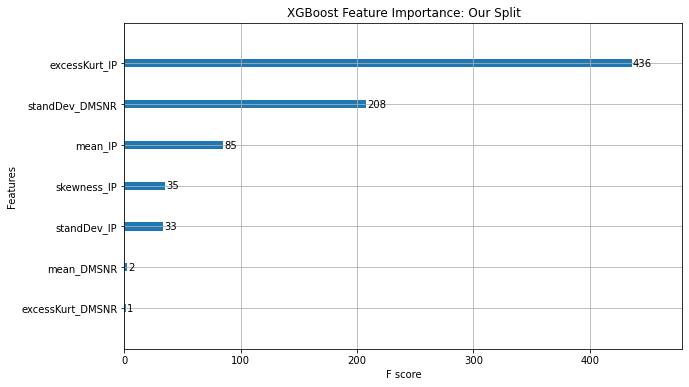

In [328]:
plt.rcParams['figure.figsize'] = [10, 6]
sh.plots.bar(
                shap_values = shap_values.abs.mean(0),
                max_display = 8,  
                order = shap_values.abs.max(0)             
            )

#Variable importance using SHAP package
plot_importance(
                    model_os_a, 
                    max_num_features=8

                )
plt.title("XGBoost Feature Importance: Our Split")
#Visualize Tree
plt.savefig(path + "/output/XGBoost_os_a_barImportance.png", bbox_inches='tight')
plt.show()

In [10]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=3, min_child_weight=10,
              monotone_constraints='()', n_estimators=600, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

model_3f_s = xgb.fit(X_train_3fold_s, y_train_3fold_s)

Accuracy: 97.92%
AUC: 93.45%
F-measure: 88.56%
Precision: 89.14%
Recall: 87.99%
XGBoost Confusion matrix: 3 Fold CV Normalized
[[5308   58]
 [  65  476]]


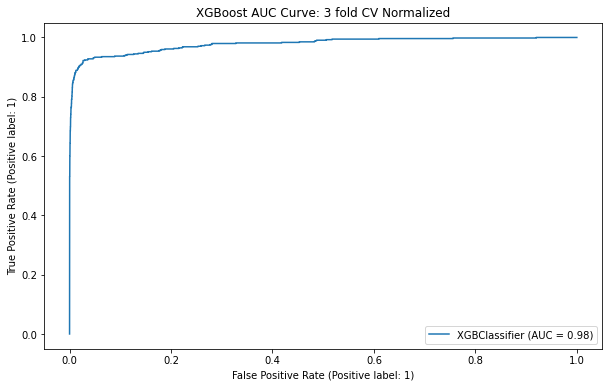

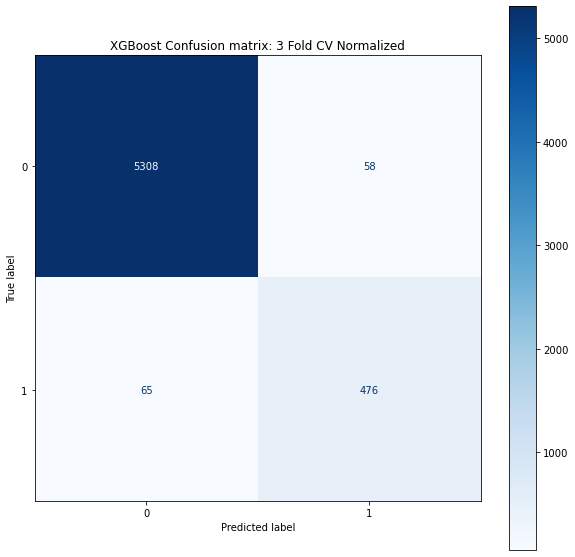

Specificity: 98.92%
False Positive Rate: 1.08%
G-mean: 88.56%


In [16]:
y_pred_s = model_3f_s.predict(X_test_3fold_s)
predictions = [round(value) for value in y_pred_s]

accuracy_s = metrics.accuracy_score(y_test_3fold_s, predictions)
print("Accuracy: %.2f%%" % (accuracy_s * 100.0))

auc_s = metrics.roc_auc_score(y_test_3fold_s, predictions)
print("AUC: %.2f%%" % (auc_s * 100.0))

plt.rcParams['figure.figsize'] = [10, 6]

disp_s = plot_roc_curve(model_3f_s, X_test_3fold_s, y_test_3fold_s)
title = "XGBoost AUC Curve: 3 fold CV Normalized"
disp_s.ax_.set_title(title)

fmeasure_s = metrics.f1_score(y_test_3fold_s, predictions)
print("F-measure: %.2f%%" % (fmeasure_s * 100.0))

precision_s = metrics.precision_score(y_test_3fold_s, predictions)
print("Precision: %.2f%%" % (precision_s * 100.0))

recall_s = metrics.recall_score(y_test_3fold_s, predictions)
print("Recall: %.2f%%" % (recall_s * 100.0))

tn, fp, fn, tp = confusion_matrix(y_test_3fold_s, predictions).ravel()

plt.rcParams['figure.figsize'] = [10, 10]

disp_s = plot_confusion_matrix(model_3f_s, X_test_3fold_s, y_test_3fold_s,
                                 cmap=plt.cm.Blues)
title = "XGBoost Confusion matrix: 3 Fold CV Normalized"
disp_s.ax_.set_title(title)

print(title)
print(disp_s.confusion_matrix)

plt.show()

specificity_s = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity_s * 100.0))

fpr_s = fp/(fp+tn)
print("False Positive Rate: %.2f%%" % (fpr_s * 100.0))

g_mean_s = math.sqrt(precision_s*recall_s)
print("G-mean: %.2f%%" % (g_mean_s * 100.0))

In [17]:
# same results as non-normalized set